In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cv2

from utils import *

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2022-11-10 18:05:04.621045: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 18:05:12.396406: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-10 18:05:37.045491: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.0/lib64:/usr/local/cuda-10.0/lib64:/lhome/ext/uv075/uv0753/miniconda3/envs/cuda/lib/:/lhome/ext/uv075/uv0753/miniconda3/envs/cuda/lib/
2022-11-10 18:05:37.046064: W tensorflow/stream_ex

In [2]:
original_perceptnet = PerceptNet(kernel_initializer = 'identity', gdn_kernel_size = 1)
original_perceptnet.compile(optimizer = 'adam', loss = PearsonCorrelation())
original_perceptnet.build(input_shape = (None, 384, 512, 3))

weights_path = tf.keras.utils.get_file(fname = 'perceptnet_rgb.h5',
                                       origin = 'https://github.com/Jorgvt/perceptnet/releases/download/Weights/final_model_rgb.h5')
original_perceptnet.load_weights(weights_path)             
print(original_perceptnet.summary())

2022-11-10 18:06:32.720483: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-10 18:06:32.727818: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: mlui01.ific.uv.es
2022-11-10 18:06:32.727853: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: mlui01.ific.uv.es
2022-11-10 18:06:32.728128: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 520.61.5
2022-11-10 18:06:32.728213: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 520.61.5
2022-11-10 18:06:32.728231: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 520.61.5
2022-11-10 18:06:32.735219: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CP

Model: "percept_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gdn (GDN)                   multiple                  8         
                                                                 
 conv2d (Conv2D)             multiple                  12        
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 gdn_1 (GDN)                 multiple                  14        
                                                                 
 conv2d_1 (Conv2D)           multiple                  456       
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                   

In [3]:
tid_path_2013 = '/lustre/ific.uv.es/ml/uv075/Databases/IQA/TID/TID2013'
data_tid_2013 = pd.read_csv(tid_path_2013 + '/image_pairs_mos.csv', index_col = 0)


def train_gen_tid2013():
    for i, row in data_tid_2013.iterrows():
        img = cv2.imread(tid_path_2013 + '/reference_images/' + row.Reference)
        dist_img = cv2.imread(tid_path_2013 + '/distorted_images/' + row.Distorted)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dist_img = cv2.cvtColor(dist_img, cv2.COLOR_BGR2RGB)
        img = img/255.0
        dist_img = dist_img/255.0
        yield img, dist_img, row.MOS

tid2013_dataset = tf.data.Dataset.from_generator(train_gen_tid2013,
                                                 output_signature=(
                                                 tf.TensorSpec(shape = (384, 512, 3), dtype=tf.float32),
                                                 tf.TensorSpec(shape = (384, 512, 3), dtype=tf.float32),
                                                 tf.TensorSpec(shape = (), dtype=tf.float32)))

print(tid2013_dataset)

<FlatMapDataset element_spec=(TensorSpec(shape=(384, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(384, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [7]:
kadik_path = '/lustre/ific.uv.es/ml/uv075/Databases/IQA/KADIK10K'
data_kadik = pd.read_csv(kadik_path + '/dmos.csv')

def train_gen_kadik():
    for i, row in data_kadik.iterrows():
        img = cv2.imread(kadik_path + '/images/' + row.ref_img)
        dist_img = cv2.imread(kadik_path + '/images/' + row.dist_img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dist_img = cv2.cvtColor(dist_img, cv2.COLOR_BGR2RGB)
        img = img/255.0
        dist_img = dist_img/255.0
        yield img, dist_img, row.dmos

kadik_dataset = tf.data.Dataset.from_generator(train_gen_kadik,
                                               output_signature=(
                                               tf.TensorSpec(shape = (384, 512, 3), dtype  =tf.float32),
                                               tf.TensorSpec(shape = (384, 512, 3), dtype = tf.float32),
                                               tf.TensorSpec(shape = (), dtype = tf.float32)))
print(kadik_dataset)

<FlatMapDataset element_spec=(TensorSpec(shape=(384, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(384, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [5]:
model_1 = tf.keras.Sequential(original_perceptnet.layers[:2])
model_1.build(input_shape=(None,384,512,3))
model_1.summary()

model_2 = tf.keras.Sequential(original_perceptnet.layers[:5])
model_2.build(input_shape=(None,384,512,3))
model_2.summary()

model_3 = tf.keras.Sequential(original_perceptnet.layers[:8])
model_3.build(input_shape=(None,384,512,3))
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gdn (GDN)                   (None, 384, 512, 3)       8         
                                                                 
 conv2d (Conv2D)             (None, 384, 512, 3)       12        
                                                                 
Total params: 20
Trainable params: 18
Non-trainable params: 2
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gdn (GDN)                   (None, 384, 512, 3)       8         
                                                                 
 conv2d (Conv2D)             (None, 384, 512, 3)       12        
                                                                 
 max_pooling2d (MaxPooling2D  (None,

In [10]:
moses, distances = [], []
for imgs, dists, mos in kadik_dataset.batch(5):
    moses.extend(mos)

    preds_img_1 = model_1(imgs).numpy()
    preds_dist_1 = model_1(dists).numpy()

    preds_img_2 = model_2(imgs).numpy()
    preds_dist_2 = model_2(dists).numpy()

    preds_img_3 = model_3(imgs).numpy()
    preds_dist_3 = model_3(dists).numpy()

    preds_img = np.concatenate([preds_img_1.reshape(5,-1), preds_img_2.reshape(5,-1), preds_img_3.reshape(5,-1)], axis = -1)
    preds_dist = np.concatenate([preds_dist_1.reshape(5,-1), preds_dist_2.reshape(5,-1), preds_dist_3.reshape(5,-1)], axis = -1)
    
    l2 = (preds_img-preds_dist)**2
    l2 = tf.reduce_sum(l2, axis = [-1])
    l2 = tf.sqrt(l2)
    distances.extend(l2)

print(stats.pearsonr(moses, distances)[0], stats.spearmanr(moses, distances)[0])

-0.6661735554686503 -0.762413560275234


In [11]:
tid_pearson = [0.598, 0.603, 0.690, 0.811]
tid_spearman = [0.687, 0.702, 0.749, 0.821] 
kadik_pearson = [0.550, 0.551, 0.595, 0.666]
kadik_spearman = [0.676, 0.677, 0.710, 0.762]

layers = ['Input', 'conv1', 'conv1 +\nconv2', 'conv1 +\nconv2 +\nconv3']

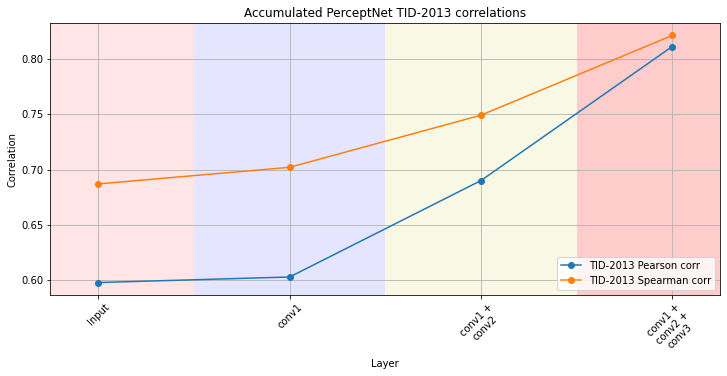

In [26]:
plt.figure(figsize=(12,5), facecolor=(1, 1, 1))
plt.plot(np.arange(0,8,2), tid_pearson, '-o', label = 'TID-2013 Pearson corr')
plt.plot(np.arange(0,8,2), tid_spearman, '-o', label = 'TID-2013 Spearman corr')
plt.axvspan(-0.5, 1, color='r', alpha=0.1, lw=0)
plt.axvspan(1, 3, color='b', alpha=0.1, lw=0)
plt.axvspan(3, 5, color='y', alpha=0.1, lw=0)
plt.axvspan(5, 7, color='r', alpha=0.2, lw=0)
plt.xticks(np.arange(0,8,2), [layer for layer in layers], rotation = 45)
plt.title('Accumulated PerceptNet TID-2013 correlations')
plt.xlabel('Layer')
plt.ylabel('Correlation')
#plt.ylim([0.5,1])
plt.xlim([-0.5,6.5])
plt.legend(loc = 'lower right')
plt.grid()
plt.show()

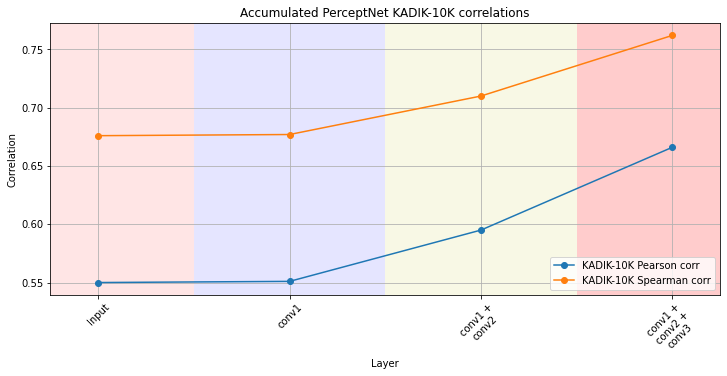

In [25]:
plt.figure(figsize=(12,5), facecolor=(1, 1, 1))
plt.plot(np.arange(0,8,2), kadik_pearson, '-o', label = 'KADIK-10K Pearson corr')
plt.plot(np.arange(0,8,2), kadik_spearman, '-o', label = 'KADIK-10K Spearman corr')
plt.axvspan(-0.5, 1, color='r', alpha=0.1, lw=0)
plt.axvspan(1, 3, color='b', alpha=0.1, lw=0)
plt.axvspan(3, 5, color='y', alpha=0.1, lw=0)
plt.axvspan(5, 7, color='r', alpha=0.2, lw=0)
plt.xticks(np.arange(0,8,2), [layer for layer in layers], rotation = 45)
plt.title('Accumulated PerceptNet KADIK-10K correlations')
plt.xlabel('Layer')
plt.ylabel('Correlation')
#plt.ylim([0.5,1])
plt.xlim([-0.5,6.5])
plt.legend(loc = 'lower right')
plt.grid()
plt.show()

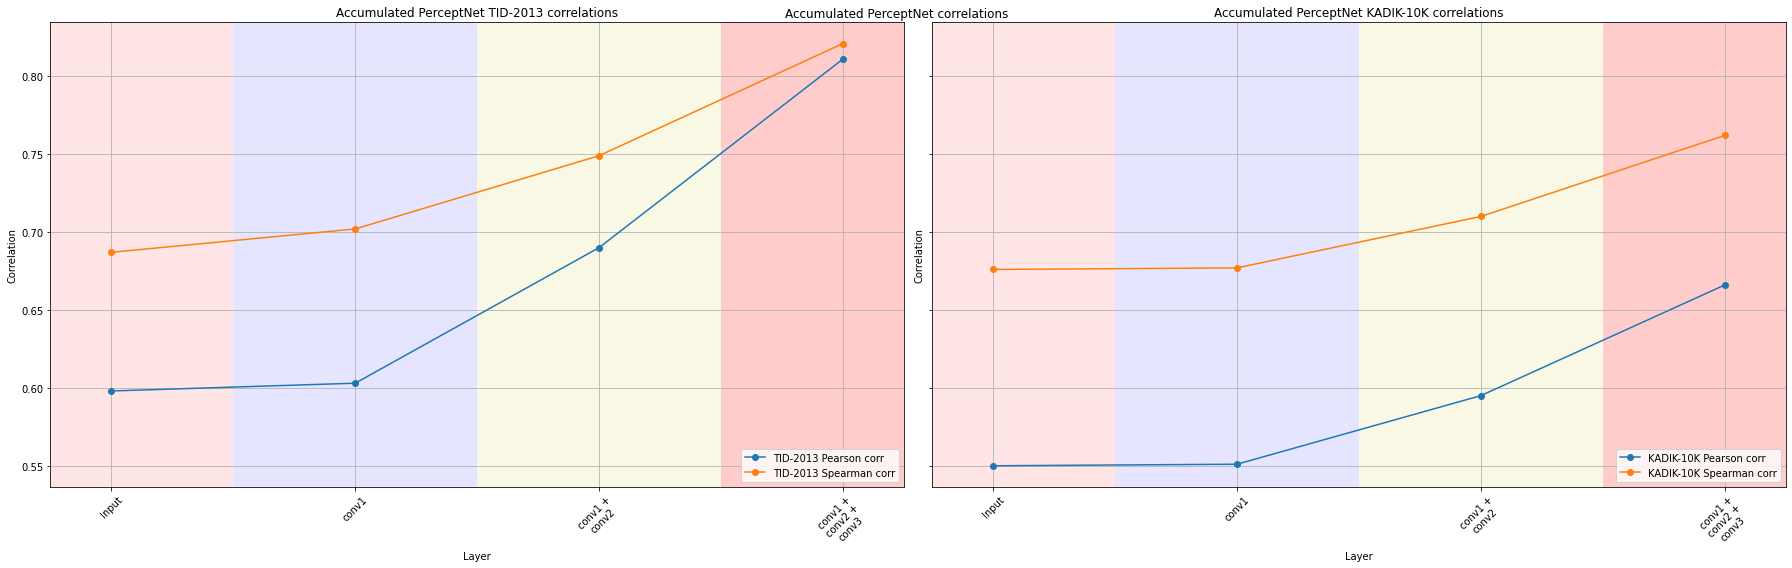

In [27]:
fig, ax = plt.subplots(1,2, sharey=True, figsize = (25,8))
ax[0].plot(np.arange(0,8,2), tid_pearson, '-o', label = 'TID-2013 Pearson corr')
ax[0].plot(np.arange(0,8,2), tid_spearman, '-o', label = 'TID-2013 Spearman corr')
ax[0].axvspan(-0.5, 1, color='r', alpha=0.1, lw=0)
ax[0].axvspan(1, 3, color='b', alpha=0.1, lw=0)
ax[0].axvspan(3, 5, color='y', alpha=0.1, lw=0)
ax[0].axvspan(5, 7, color='r', alpha=0.2, lw=0)
ax[0].set_xticks(np.arange(0,8,2), [layer for layer in layers], rotation = 45)
ax[0].set_title('Accumulated PerceptNet TID-2013 correlations')
ax[0].set_xlabel('Layer')
ax[0].set_ylabel('Correlation')
ax[0].set_xlim([-0.5,6.5])
ax[0].legend(loc = 'lower right')
ax[0].grid()

ax[1].plot(np.arange(0,8,2), kadik_pearson, '-o', label = 'KADIK-10K Pearson corr')
ax[1].plot(np.arange(0,8,2), kadik_spearman, '-o', label = 'KADIK-10K Spearman corr')
ax[1].axvspan(-0.5, 1, color='r', alpha=0.1, lw=0)
ax[1].axvspan(1, 3, color='b', alpha=0.1, lw=0)
ax[1].axvspan(3, 5, color='y', alpha=0.1, lw=0)
ax[1].axvspan(5, 7, color='r', alpha=0.2, lw=0)
ax[1].set_xticks(np.arange(0,8,2), [layer for layer in layers], rotation = 45)
ax[1].set_title('Accumulated PerceptNet KADIK-10K correlations')
ax[1].set_xlabel('Layer')
ax[1].set_ylabel('Correlation')
ax[1].set_xlim([-0.5,6.5])
ax[1].legend(loc = 'lower right')
ax[1].grid()
fig.tight_layout()
plt.suptitle('Accumulated PerceptNet correlations')
plt.show()
#plt.savefig('VGG_correlations.png', dpi = 1000)